# Simulation and EM Maximization of the 1D Simple Likelihood for scRNA-seq

In this exercise, I generate some data that (could) look like RNA seq in 1 dimension under some assumptions, and design a likelihood function that could recover (some) parameters.

I describe an EM-like optimization algorithm to approximately maximize this objective.

This notebook contains the groundwork and simulation for modeling the latent variables as a log normal distribution, rather than the normal distribution that I attempted first.

### Imports

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
import itertools
import time

### 1D Likelihood Function - UPDATE FOR LOG NORMAL

I define the log liklihood given data $x_1, x_2, x_3, x_4, ... , x_N$as follows:

$$ LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) = \sum_{i=1}^{N}\log\bigg(\sum_{z=0}^{\infty} \bigg[{z\choose{x_i}}p^{x_i}(1-p)^{z-x_i}\bigg] \bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\bigg(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\bigg)\bigg]\bigg) $$

### Ideal optimization problem

This likelihood function is obviously not concave (so maximizing is not a convex optimization problem), but it may be possible to design some optimization procedure for finding good parameters, given some reasonable constraints on $p$ the dropout rate and $\mu$ the mean estimated from either pseudobulks for bulk RNA-seq experiments.

The optimization problem we'd like to eventually solve is:

\begin{equation*}
\begin{aligned}
& \underset{p,\ \mu,\ \sigma}{\text{maximize}}
& & LL(p, \mu, \sigma ; x_1, x_2, x_3, x_4, ... , x_N) \\
& \text{subject to}
& & 0.05 < p < 0.15, \\
&&& \mu_{min}\ <\ \mu\ <\ \mu_{max}
\end{aligned}
\end{equation*}

The follow outlines an EM algorithm that converges to a local maximum of this objective.

### Function for fitting a weighted lognormal distribution

In [460]:
def fit_lognormal(x, w=None):
    
    lnx = np.log(x[x > 0])
    muhat = np.average(lnx, weights=w[x > 0])
    varhat = np.average((lnx - muhat)**2, weights=w[x > 0])
    
    return np.sqrt(varhat), np.exp(muhat)

### Simulation - UPDATE FOR LOG NORMAL

Let us simulate a possible procedure for generadting scRNA-seq data in 1 dimension (1 gene case).


1. The underlying distribution Z is mean $\mu$ with variance $\sigma^{2}$, $Z \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
$
2. Then, for each cell sampled from this distribution, we round to the nearest integer and sample a binomial random variable X distributed as $X \sim Bn(round(Z), p)$ where the sampled $Z$ serves as the number of trials and $p$ serves as the dropout rate of an individual transcript in a cell.

For this simulation, we use:
- $N$ = 100,000
- $\mu$ = 3
- $\sigma$ = 1
- $p$ = 0.1

minimum parameters

num_cells = 1000
s = .6
scale = 1.5
p=0.1


In [461]:
# Parameters
num_cells = 10000
s = 0.6
scale = 3
p=0.1

In [462]:
continuous = stats.lognorm.rvs(s=s, scale=scale, size=num_cells)
normal_continuous = stats.norm.rvs(loc=np.log(scale), scale=s, size=num_cells)

In [463]:
ground_truth_counts = np.clip(np.round(continuous), a_min=0, a_max=10000).astype(np.int64)

In [464]:
observed = np.random.binomial(n=ground_truth_counts, p=p)

In [495]:
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1);
# sns.distplot(ground_truth_counts, kde=False);
# sns.distplot(observed, kde=False);
# plt.subplot(1, 2, 2);
# sns.distplot(continuous, bins=40, kde=False);
# sns.distplot(normal_continuous, bins=40, kde=False);

In [496]:
s, loc, scale  = stats.lognorm.fit(ground_truth_counts, loc=0)
print('Best possible estimate of s:', s)
print('Best possible estimate of scale:', scale)

Best possible estimate of s: 0.5454984840619076
Best possible estimate of scale: 3.345520440585865


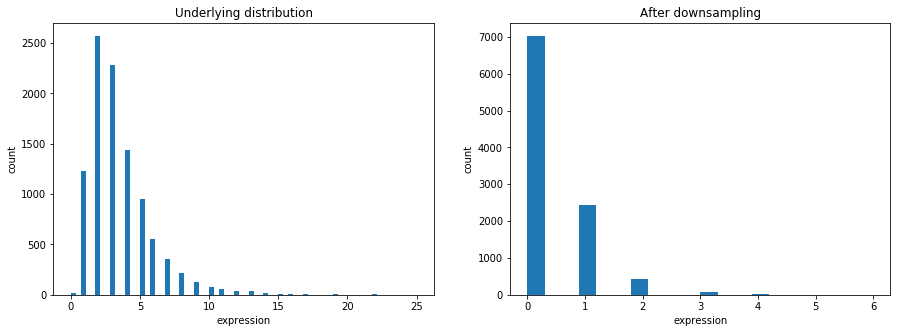

In [497]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1);
plt.title('Underlying distribution')
plt.hist(ground_truth_counts, bins=70);
plt.xlabel('expression');plt.ylabel('count')
plt.subplot(1, 2, 2);
plt.title('After downsampling')
plt.xlabel('expression');plt.ylabel('count')
plt.hist(observed, bins=20);

### Expectation step: Computing probabilities for Z

The expectation step of the EM algorithm involves calculating the probability of each possible value of Z the hidden variable (in our case, the true expression) given the parameters and the observations (X, mu, sigma, and p).

We use the Bayes rule to construct our probabilites for the hidden variables:

$ P(Z | X) = \frac{P(X|Z)P(Z)}{P(X)} $

Because of our distributional assumptions, we can evaluate each of the values on the RHS given p, mu, and sigma:

$
P(X|Z) = {z\choose{x}}p^{x}(1-p)^{z-x} \\
P(Z) = \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\big(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\big) \\
P(X) = \sum_{z=0}^{\infty} \bigg[{z\choose{x}}p^{x}(1-p)^{z-x}\bigg]\bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\big(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\big)\bigg]
$

In [468]:
def rv_pmf(x, s, scale):
    """ PDF/PMF of the random variable under use. """
    
    return stats.lognorm.pdf(x, s=s, loc=0, scale=scale)

    return stats.lognorm.cdf(x + 0.5, s=s, loc=0, scale=scale) - stats.lognorm.cdf(x - 0.5, s=s, loc=0, scale=scale)

In [469]:
def create_px_table(s, scale, p):
    return np.array([
        (rv_pmf(np.arange(x, 20), s, scale) * stats.binom.pmf(x, np.arange(x, 20), p)).sum()
        for x in range(30)])

In [470]:
def create_pz_table(s, scale, p):
    """ Returns a matrix M x M where rows indicate X and columns indicate Z """
    
    px_table = create_px_table(s, scale, p)
    table = np.zeros(shape=(20, 20))
    for x in range(20):
        for z in range(x, 20):
            table[x, z] = rv_pmf(z, s, scale) * stats.binom.pmf(x, z, p) / px_table[x]
    return table

### Maximization step: Fit a weighted Gaussian on the latent variables

The maximization step in the EM algorithm involves using the calculated values of $P(Z|X)$ above to fit new values of the parameters mu, sigma, and p.

In the 1D case, this is rather simple: we expand out each observation $ X = i $ to ~30 different values with different weights. For example, if we observed a cell with $ X = 1 $, we create 20 rows for this cell with different values of Z that it could have had. Then, we fit a Gaussian (calculate mean and variance) on those Z values, with using the previously calculated $P(Z|X)$ as weights. More concretely, we calculate the mean and variance as follows, when we consider the upper limit of $Z$ to be $Z_{max}$:

$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \bigg( \sum_{z=x_i}^{Z_{max}}\big[ P(z|x_i)(z)    \big]\bigg) \\
\hat{\sigma}^2 = \frac{1}{N-1}\sum_{i=1}^{N}\bigg( \sum_{z=x_i}^{Z_{max}}\big[ P(z|x_i)(z - \hat{\mu})^2 \big]\bigg)
$

In [471]:
def get_parameters(observed, prob_table):
    """ Get the parameters of the Gaussian and dropout """
    
    data = pd.DataFrame()
    data['observed'] = observed
    data = data.groupby('observed').size().reset_index(name='count')
    data['observed_weight'] = data['count'] / len(observed)
    data = data.merge(
        pd.concat(
            [pd.DataFrame(
                np.concatenate(
                    [np.ones(20-x).reshape(-1, 1)*x, 
                    np.arange(x, 20).reshape(-1,1),
                    prob_table[x, x:].reshape(-1, 1)], axis=1), 
                columns=['observed', 'latent', 'latent_weight']) for x in range(20)]),
        on='observed', 
        how='left')
    data['point_weight'] = data['observed_weight'] * data['latent_weight']
    data['p_estimates'] = (data['observed'] / data['latent'] * data['point_weight']).fillna(0.0).replace(np.inf, 0.0)
    p_estimate =p #min(max(data['p_estimates'].sum(), 0.05), 0.15)
    
    s, scale = fit_lognormal(data['latent'].values, w=data['point_weight'].values)
    
    return s, scale, p_estimate

### Perform EM

In [472]:
# Initialize hyperparameters for EM
NUM_ITER = 100

In [473]:
# Initialize the parameters
p_hat = p
s_hat = 5
scale_hat = 100

In [474]:
fitting_progress = []
for itr in range(NUM_ITER):
    
    fitting_progress.append((itr, s_hat, scale_hat, p_hat))
    
    # E step
    prob_table = create_pz_table(s_hat, scale_hat, p_hat)
    
    # M step
    s_hat, scale_hat, p_hat = get_parameters(observed, prob_table)

/anaconda3/envs/scvi/lib/python3.6/site-packages/pandas/core/ops.py:710: RuntimeWarning: invalid value encountered in true_divide
  lambda x: op(x, rvalues))
/anaconda3/envs/scvi/lib/python3.6/site-packages/pandas/core/ops.py:710: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: op(x, rvalues))


In [475]:
fitting_progress = pd.DataFrame(fitting_progress, columns=['iteration', 's_hat', 'scale_hat', 'p_hat'])

Text(0.5,1,'log(scale) [mu]')

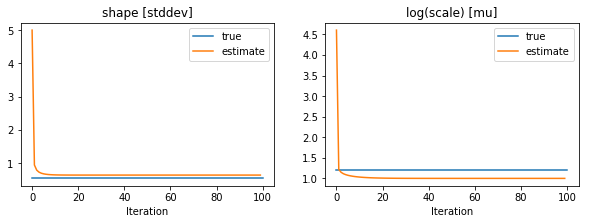

In [498]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot([0, NUM_ITER], [s, s])
plt.plot(fitting_progress.iteration, fitting_progress.s_hat)
plt.xlabel('Iteration'); plt.legend(['true', 'estimate']); plt.title('shape [stddev]')
plt.subplot(1, 2, 2)
plt.plot([0, NUM_ITER], [np.log(scale), np.log(scale)])
plt.plot(fitting_progress.iteration, np.log(fitting_progress.scale_hat))
plt.xlabel('Iteration'); plt.legend(['true', 'estimate']); plt.title('log(scale) [mu]')

### Re-create the original distribution

Sample a Log-normal distribution with the estimated parameters.

In [477]:
reconstructed_counts = np.clip(
    np.round(stats.lognorm.rvs(s=s, scale=scale, size=num_cells) ),
    a_min=0, 
    a_max=1000).astype(np.int64)

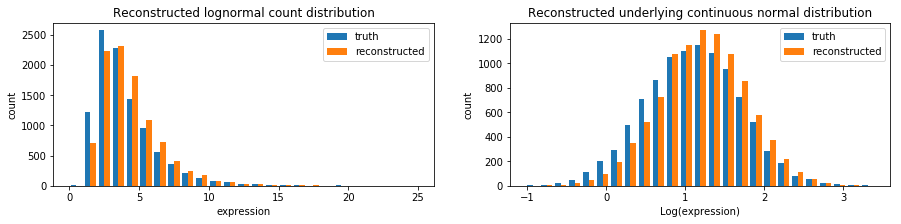

In [505]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1);
plt.hist([ground_truth_counts, reconstructed_counts], bins=25);
plt.xlabel('expression');plt.ylabel('count'); plt.legend(['truth', 'reconstructed']);
plt.title('Reconstructed lognormal count distribution');

plt.subplot(1, 2, 2);
plt.hist([normal_continuous, reconstructed_normal], bins=25);
plt.xlabel('Log(expression)');plt.ylabel('count'); plt.legend(['truth', 'reconstructed'])
plt.title('Reconstructed underlying continuous normal distribution');